#Bermudan Swaption Valuation Under The Hull White Model

This notebook regroup the total code and all the documentation for the interest rate projet of the Course given at Centrale Marseille by Mr Abderrahim Ben Jazia .<br />Author Name : Audric Dongfack Kengfack<br /> 
Email:(dongfackaudric@gmail.com)<br /> Linkedin : linkedin.com/in/audricdongfack



In [ ]:
!pip install nelson_siegel_svensson
!pip install QuantLib

     |████████████████████████████████| 17.4MB 276kB/s 


In [ ]:
#Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#===============================
#for the calibration part
import QuantLib as ql 
from collections import namedtuple
import math
#===============================
sns.set()
%matplotlib inline  


##Question 2 - Calibration of the Nelson Siegel Model

For this question, i built my dataset using data available on the ECB website. The data contains two columns, one representing maturities in years and another representing prices.
The link of the brut dataset is there : 

https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html


In [ ]:
#I load my   data 
ZC_Yield_Curve = pd.read_csv("data_ZC_Yield_Curve.csv")

In [ ]:
ZC_Yield_Curve.head(2)

,Maturity,Price
0,0.25,0.001486
1,0.50,0.002666


In [ ]:
ZC_Yield_Curve.Price #The Price Column

0      0.001486
1      0.002666
2      0.004233
3      0.005965
4      0.007754
         ...   
115    0.040028
116    0.039977
117    0.039928
118    0.039881
119    0.039835
Name: Price, Length: 120, dtype: float64

In [ ]:
#Here we construct take a subset of my dataset (with just 2 columns)
 ZC_Yield_Curve_Data = pd.DataFrame(ZC_Yield_Curve, columns = ['Maturity', 'Price']) 

In [ ]:
ZC_Yield_Curve_Data.head(2)

,Maturity,Price
0,0.25,0.001486
1,0.50,0.002666


Text(0, 0.5, 'Price')

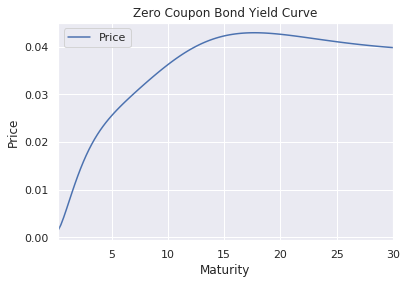

In [ ]:
#I draw the curve with the data
figure = ZC_Yield_Curve_Data.plot(x='Maturity', y = 'Price', title ="Zero Coupon Bond Yield Curve" )
figure.set_ylabel("Price")


First approach i  use the the nelson siegel library developpe by luphord luphord@protonmail.com . The link of the website is : https://nelson-siegel-svensson.readthedocs.io/en/latest/readme.html

In [ ]:
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
from nelson_siegel_svensson.calibrate import calibrate_ns_ols


In [ ]:
t = np.array(ZC_Yield_Curve_Data.Maturity)
y = np.array(ZC_Yield_Curve_Data.Price)

curve, status = calibrate_ns_ols(t, y, tau0=1.0)  # starting value of 1.0 for the optimization of tau
assert status.success
print(curve)

NelsonSiegelCurve(beta0=0.04667636232318473, beta1=-0.04572289071926614, beta2=-0.039263323137185946, tau=1.2385573595407124)


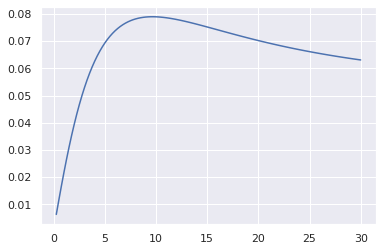

In [ ]:
yexamplet = NelsonSiegelSvenssonCurve(0.04667636232318473,-0.04572289071926614,-0.039263323137185946,0.15,1.2385573595407124,4.0)
texamplet = np.array(ZC_Yield_Curve_Data.Maturity)
plt.plot(texamplet, yexamplet(texamplet))

We define the [Nelson-Siegel](https://en.wikipedia.org/wiki/Fixed-income_attribution#Modeling_the_yield_curve) function:
$$y(t) = \beta_0 + \beta_1 \frac{1-\exp(-t/\lambda)}{t/\lambda} + \beta_2 (\frac{1-\exp(-t/\lambda)}{t/\lambda} - \exp(-t/\lambda))$$

In [ ]:
#we define the nelson siegel function
def nelson_siegel(term, beta0, beta1, beta2,lambda_par):
    return (beta0 +beta1*(1-np.exp(-term/lambda_par))/(term/lambda_par) 
    +beta2*((1-np.exp(-term/lambda_par))/(term/lambda_par)-np.exp(-term/lambda_par)))
            

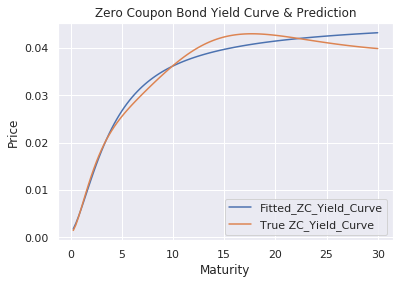

In [ ]:
# Comparison Graph between the true ZC_Yield_Curve and the fitted one
Fitted_ZC_Yield_Curve=[nelson_siegel(elem,0.04667636232318473,-0.04572289071926614,-0.039263323137185946,1.2385573595407124) for elem in t] #t is the array of maturity 
plt.plot(t,Fitted_ZC_Yield_Curve)
plt.plot(t,y)
plt.legend(["Fitted_ZC_Yield_Curve","True ZC_Yield_Curve"])
plt.xlabel("Maturity")
plt.ylabel("Price")
plt.title("Zero Coupon Bond Yield Curve & Prediction")
plt.show()

##Question 3 - Instantaneous forward rate 

The expresion of the instantaneous forward rate under the Nelson Siegel Characterization is :
$$ f(\tau) = \beta_{0} +\beta_{1}e^{\frac{-\tau}{\lambda}} +\beta_{2}(\frac{\tau}{\lambda})e^{\frac{-\tau}{\lambda}}$$

In [ ]:
#definition of the instantaneous forward rate 
def instantaneous_forward_rate(term, beta0, beta1, beta2,lambda_par):
    return (beta0 +beta1*np.exp(-term/lambda_par) 
    +beta2*(term/lambda_par)*np.exp(-term/lambda_par))

Text(0, 0.5, 'Forward rate')

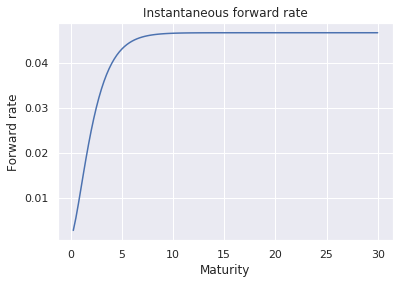

In [ ]:
#graph of the instantaneous forward rate 
forward_rate_curve=[instantaneous_forward_rate(elem,0.04667636232318473,-0.04572289071926614,-0.039263323137185946,1.2385573595407124) for elem in t] #t is the array of maturity 
plt.plot(t,forward_rate_curve)
plt.title("Instantaneous forward rate")
plt.xlabel("Maturity")
plt.ylabel("Forward rate")

##Question 4 - The parameter  $\theta$

The expresion of the parameter $\theta$ is given by :
$$\theta(\tau) =a\beta_{0} + (a-\frac{1}{\lambda})\beta_{1}e^{\frac{-\tau}{\lambda}} +(\frac{1}{\lambda}+\frac{\tau}{\lambda}(a-\frac{1}{\lambda}))\beta_{2}e^{\frac{-\tau}{\lambda}} + \frac{\sigma^{2}}{2a}(1-e^{-2a\tau})$$

In [ ]:
#definition of parameter theta function 
#recall that here we need to fixed a and sigma
def parameter_theta(term, beta0, beta1, beta2,lambda_par,a,sigma):
    return (a*beta0 +(a-1/lambda_par)*beta1*np.exp(-term/lambda_par) 
    +(1/lambda_par + (term/lambda_par)*(a-1/lambda_par))*beta2*(term/lambda_par)*np.exp(-term/lambda_par) + (sigma**2/2*a)*(1-np.exp(-2*term/lambda_par)))

Text(0, 0.5, 'theta value')

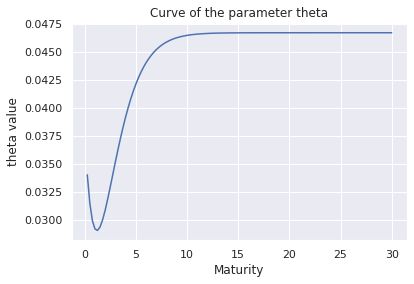

In [ ]:
#graph of the instantaneous forward rate 
#here we use a = 1 and sigma = 0.01
theta_curve=[parameter_theta(elem,0.04667636232318473,-0.04572289071926614,-0.039263323137185946,1.2385573595407124,1,0.01) for elem in t] #t is the array of maturity 
plt.plot(t,theta_curve)
plt.title("Curve of the parameter theta")
plt.xlabel("Maturity")
plt.ylabel("theta value")

#Trinomial Tree  

##Question 5 - Construction of the auxillary tree for a 10 years period (First stage)

Construct the auxilliary tree is simply contruct the  sparse matric of $R_{i,j}^{*}$.

To do that, we procede as follow. 
first we get total nodes at  each time i. And second , in this each nodes we put the corresponding value $R_{i,j}^{*} = j \Delta R^{*}$.

This procedure for the first stage is well explain in  (chourdaskis,2008)

In [ ]:
#Here we define the function get_nodes that takes an array of nodes at time i and return and array of nodes at time i+1

def get_nodes(array_nodes,a,dt):
  futur_array_nodes = []
  for j in array_nodes:
    k = np.round(j*np.exp(-a*dt),decimals=0)
    futur_array_nodes += [k-1,k,k+1]
  futur_array_nodes = list(set(futur_array_nodes))  #we set the list to avoid the repetition of any future node 
  futur_array_nodes.sort() #we arrange our table in ascending order
  return futur_array_nodes  
   


In [ ]:
#now we represent the sparse matrix (auxilliary tree)
#array of different nodes we have at each time i < = 10 years, because we take here dt = 1
nodes = [[-1,0,1]]
initial_nodes = [-1,0,1]
for i in range(1,10):
  new_nodes = get_nodes(initial_nodes,0.1,1)
  nodes.append(new_nodes)
  initial_nodes = new_nodes



In [ ]:
#tree
nodes

[[-1, 0, 1],
 [-2.0, -1.0, 0.0, 1.0, 2.0],
 [-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0],
 [-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0],
 [-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0],
 [-6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0],
 [-6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0],
 [-6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0],
 [-6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0],
 [-6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]]

Text(0, 0.5, 'Space j')

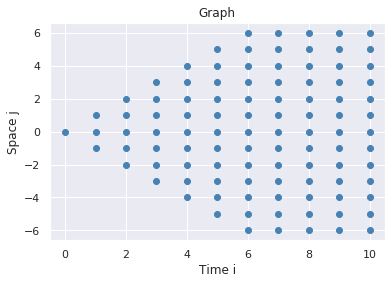

In [ ]:
#now we plot the tree
for time,elem in enumerate(nodes):
  for value in elem:
    plt.plot(time+1,value,'o',color="steelblue")
plt.plot(0,0,'o',color="steelblue")
plt.title("Graph")
plt.xlabel("Time i")
plt.ylabel("Space j")

In [ ]:
#nodes size-nodes-element
sizenodeselem=[]
for elem in nodes:
  sizenodeselem.append(len(elem))

In [ ]:
print(sizenodeselem)

[3, 5, 7, 9, 11, 13, 13, 13, 13, 13]


In [ ]:
#We construct the first stage 
#According to the visualisation of the graph above 
#We call 
#Pu : Probability of an upward move
#Pd : Probability of a downward move
#Pm : Probability of a median move

#initialisation
#==================================
sigma = 0.01
a = 0.1
maturity = 10
steps = 10
dt = maturity/steps
jmax = 6
#===================================

#we define the process, the nodes and the probabilities of each node. the time start at date i = 1

Rstar = np.zeros((2*jmax+1,maturity))
pu = np.zeros((2*jmax+1,maturity))
pm = np.zeros((2*jmax+1,maturity))
pd = np.zeros((2*jmax+1,maturity))
#Compared to the previous graph, we only have a problem to define the probabilities
# of the extreme nodes at time 6 , 7 , 8 and 9 
#which we are goind  to correct at the end of the algorithm

for i in range(1,6):
  jmaxx = sizenodeselem[i-1]
  for j in range(0,jmaxx):
    jreal =  (jmaxx-1)/2 -j
    #we compute the process and the probabilities of branching
    k = np.round(jreal*np.exp(-a*dt),decimals=0)
    deltaR = sigma*np.sqrt(3/(2*a)*(1-np.exp(-2*a*dt)))
    Mj = jreal*deltaR*np.exp(-a*dt)
    V = (sigma**2/(2*a))*(1-np.exp(-2*a*dt))
    netaj = Mj-k*deltaR
    Rstar[j,i]= jreal*deltaR
    pu[j,i] = 1/6+netaj**2/(6*V)+netaj/(2*np.sqrt(3*V))
    pm[j,i] = 2/3-netaj**2/(3*V)
    pd[j,i] = 1/6+netaj**2/(6*V)-netaj/(2*np.sqrt(3*V))

#we detail this part just to show that due to the mean reversion, the probability must change
#at the bottom of the tree in Jmax and -Jmax
#according to the project it is not realy the case 
for i in range(6,10):
  jmaxx = 13
  for j in range(0,jmaxx):
    jreal = (jmaxx-1)/2 - j
    #we compute the process and the probabilities of branching
    k = np.round(jreal*np.exp(-a*dt),decimals=0)
    deltaR = sigma*np.sqrt(3/(2*a)*(1-np.exp(-2*a*dt)))
    Mj = jreal*deltaR*np.exp(-a*dt)
    V = (sigma**2/(2*a))*(1-np.exp(-2*a*dt))
    netaj = Mj-k*deltaR
    Rstar[j,i]= jreal*deltaR
    if j == 0 :
      pu[j,i] = 1/6 + netaj**2/(6*V)+netaj/(2*np.sqrt(3*V))
      pm[j,i] = 2/3 - netaj**2/(3*V)
      pd[j,i] = 1/6 + netaj**2/(6*V)-netaj/(2*np.sqrt(3*V))
    elif j==jmaxx:
      pu[j,i] = 1/6 + netaj**2/(6*V)-netaj/(2*np.sqrt(3*V))
      pm[j,i] = 2/3-netaj**2/(3*V)
      pd[j,i] = 1/6 + netaj**2/(6*V)-netaj/(2*np.sqrt(3*V))
    else : 
      pu[j,i] = 1/6 + netaj**2/(6*V)+netaj/(2*np.sqrt(3*V))
      pm[j,i] = 2/3-netaj**2/(3*V)
      pd[j,i] = 1/6 + netaj**2/(6*V)-netaj/(2*np.sqrt(3*V))

    





In [ ]:
print(Rstar[0,1],Rstar[1,1],Rstar[2,1])

0.016489507887836655 0.0 -0.016489507887836655


##Question 6 - Construction of the process $Q_{i,j}$

In [ ]:
#We construct the second stage process 
Q = np.zeros((2*jmax+1,maturity))
theta = maturity*[0.0]

In [ ]:
print(theta)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
#we define the function jmax
#this function give the jmax of the tree (optional function since we now the value of jmax (6))
#def j_max(nodes,a,dt):
  #return (len(nodes)-1)/2


In [ ]:
# we first define the probability transition between the node (i,h) to the node (i+1,j)
#Pu : Probability of an upward move
#Pd : Probability of a downward move
#Pm : Probability of a median move
def q(i,h,j,a,sigma,dt):
    #jmax = j_max(nodes,a,dt) to generalize the function
    jmax = 6
    k = np.round(h*np.exp(-a*dt),decimals=0)
    deltaR = sigma*np.sqrt(3/(2*a)*(1-np.exp(-2*a*dt)))
    Mj = h*deltaR*np.exp(-a*dt)
    V = sigma**2/(2*a)*(1-np.exp(-2*a*dt))
    netaj = Mj-k*deltaR
    pu = 1/6+netaj**2/(6*V)+netaj/(2*np.sqrt(3*V))
    pm = 2/3-netaj**2/(3*V)
    pd = 1/6+netaj**2/(6*V)-netaj/(2*np.sqrt(3*V))
    
    
    if j>jmax or h>jmax or h<-jmax:
        return 0
    else :
        if i< jmax:
            if j == h-1:
                return pd
            elif j == h:
                return pm
            elif j == h+1:
                return pu
            else :
                return 0
        else :
            if -jmax< h <jmax:
                if j==h-1:
                    return pd
                elif j == h:
                    return pm
                elif j == h+1:
                    return pu
                else :
                    return 0
                
            elif h == jmax:
                if j == h:
                    return pu
                elif j == h-1:
                    return pm
                elif j == h-2:
                    return pd
                else :
                    return 0
            
            elif h == -jmax:
                if j == h:
                    return pd
                elif j == h+1:
                    return pm
                elif j == h+2:
                    return pu
                else :
                    return 0

In [ ]:
#verification that the probability is well define 
q(0,0,-1,0.1,0.01,1) 

0.16666666666666666

In [ ]:
#we create list for the Zero coupond bond maturity base on data  
ZC = [0.00596481,0.012907481,0.01847603,0.022517886,0.025528996,0.02799328,0.030214566,0.032326139,0.034348445,0.036244585]

In [ ]:
#First time steps
#since dt = 1, devide by 1 don't affect the ratio
Q = np.zeros((2*jmax+1,maturity))
theta = maturity*[0.0]
Q[0,0] = 1
theta[0]= ZC[0]

In [ ]:
#Second time steps
Q[0,1]=Q[0,0]*pu[0,1]*np.exp(-ZC[0]*dt)
Q[1,1]=Q[0,0]*pm[1,1]*np.exp(-ZC[0]*dt)
Q[2,1]=Q[0,0]*pd[2,1]*np.exp(-ZC[0]*dt)
addition = Q[0,1]*np.exp(-dt*Rstar[0,1])+Q[1,2]*np.exp(-dt*Rstar[1,1])+Q[2,1]*np.exp(-dt*Rstar[0,1])
theta[1]= -np.log(ZC[0]/addition)


In [ ]:
print(theta)

[0.00596481, 3.7019740810843857, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:

#other time steps
for i in range(2,10):
  jmaxx = sizenodeselem[i-1]
  somme = 0
  sommeun = 0
  for j in range(0,jmaxx):
    jreal = (jmaxx-1)/2 - j
    for h in range(0,jmaxx):
      hreal = (jmaxx-1)/2 - h
      somme = somme + Q[h,i-1]*q(i-1,hreal,jreal,a,sigma,dt)*np.exp(-1*(theta[i-1] + Rstar[h,i-1]))
    Q[j,i] = somme
    somme = 0
  #we compute the new theta(i)
  for j in range(0,jmaxx) : 
    jreal = (jmaxx-1)/2 - j
    sommeun = sommeun + Q[j,i-1]*np.exp(-Rstar[j,i-1])
  theta[i] = -np.log(ZC[i]/sommeun)
  #and the loop go forward


        

In [ ]:
#print(Q)
print(theta)

[0.00596481, 3.7019740810843857, 3.8953116149927123, -0.03085961394642545, -4.090253098448104, -4.197945073785415, -0.23828912258777152, 3.8036718039353734, 3.9280681874265992, 0.022857721548726125]


## Contruction of the  process $R_{i,j}$

We have $R_{i,j} = R_{i,j}^{*} + \theta (i)$

In [ ]:
#we define the matrix R
R = np.zeros((2*jmax+1,maturity))
R[0,0] = theta[0]

In [ ]:
#maturity = 10
for i in range(1,10):
  jmaxx = sizenodeselem[i-1]
  for j in range(0,jmaxx):
    R[j,i] = Rstar[j,i] + theta[i]

In [ ]:
print(R)

[[ 5.96481000e-03  3.71846359e+00  3.92829063e+00  1.86089097e-02
  -4.02429507e+00 -4.11549753e+00 -1.39352075e-01  3.90260885e+00
   4.02700523e+00  1.21794769e-01]
 [ 0.00000000e+00  3.70197408e+00  3.91180112e+00  2.11940183e-03
  -4.04078457e+00 -4.13198704e+00 -1.55841583e-01  3.88611934e+00
   4.01051573e+00  1.05305261e-01]
 [ 0.00000000e+00  3.68548457e+00  3.89531161e+00 -1.43701061e-02
  -4.05727408e+00 -4.14847655e+00 -1.72331091e-01  3.86962984e+00
   3.99402622e+00  8.88157531e-02]
 [ 0.00000000e+00  0.00000000e+00  3.87882211e+00 -3.08596139e-02
  -4.07376359e+00 -4.16496606e+00 -1.88820599e-01  3.85314033e+00
   3.97753671e+00  7.23262452e-02]
 [ 0.00000000e+00  0.00000000e+00  3.86233260e+00 -4.73491218e-02
  -4.09025310e+00 -4.18145557e+00 -2.05310107e-01  3.83665082e+00
   3.96104720e+00  5.58367373e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -6.38386297e-02
  -4.10674261e+00 -4.19794507e+00 -2.21799615e-01  3.82016131e+00
   3.94455770e+00  3.93472294e-02

#Question 7 - Values of $\theta (i)$


Note here that practically, the determination of $\theta(i)$ is done at the same time as the construction of the values ​​$Q(i,j)$.

Text(0, 0.5, 'theta value')

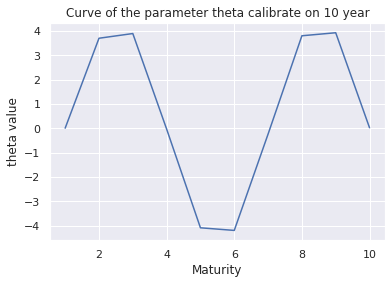

In [ ]:
#visualisation of the theta(i) graph
time=[1,2,3,4,5,6,7,8,9,10]
plt.plot(time,theta)
plt.title("Curve of the parameter theta calibrate on 10 year")
plt.xlabel("Maturity")
plt.ylabel("theta value")



#Question 8 - Tree for the libor Rate $L(T_{i},T_{i+1})$
 
$$
L(T_{i},T_{i+1}) = \frac{1}{\Delta T} (e^{R_{i}\Delta T} -1)
$$
Constructing the libor tree is therefore equivalent to constructing at each node the value of the corresponding libor.

In [ ]:
#we define the matrix Libor Libor[.,i] is exactly the same as Libor[Ti,Ti+1] view at node (i,.)
#since DeltaT = 1
Libor = np.zeros((2*jmax+1,maturity))
Libor[0,0] = np.exp(R[0,0]) - 1

In [ ]:
#maturity = 10
for i in range(1,10):
  jmaxx = sizenodeselem[i-1]
  for j in range(0,jmaxx):
    Libor[j,i] = np.exp(R[j,i]) - 1

In [ ]:
print(Libor)

#Question 9 - Valuation procedure of the Swap between $(T_{0},T_{10}) = (0,10)$ with fixed leg $ 2\% $

At each J-node, the swap price is given by the following expression (We take the nominal equal to 1):
$$SwapPrice_{i,j} = [p_{u} SwapPrice_{i+1,k+1} + p_{m}SwapPrice_{i+1,k}+ p_{d} SwapPrice_{i+1,k-1}] + e^{-R_{i,j}}(Libor(T_{i},T_{i+1}) -K)$$

In [ ]:
SwapPrice = np.zeros((2*jmax+1,maturity))

In [ ]:
#we define the Swap price tree price of the swapp between (T0,T10)
#Delta t = 1
k = 0.02
for i in range(7,-1,-1):
  jmaxx = sizenodeselem[i-1]
  for j in range(0,jmaxx):
    jreal = (jmaxx-1)/2 - j
    kk = np.round(jreal*np.exp(-a*dt),decimals=0)
    ku =(jmaxx-1)/2-kk-1 
    km = (jmaxx-1)/2-kk
    kd = (jmaxx-1)/2-kk+1
    if ku>=0 and km>=0 and kd>=0 and kd<=9:
      SwapPrice[j,i] = pu[j,i]*SwapPrice[int(ku),i+1]  + pm[j,i]*SwapPrice[int(km),i+1] + pd[j,i]*SwapPrice[int(kd),i+1] + np.exp(-R[j,i])*(Libor[j,i]-k)


In [ ]:
#the swap price is given by the initial element SwapPrice[0,0]
#print(SwapPrice[0,0])

#Question 11 - Valuation Valuation of the caplet between $(T_{9},T_{10})$ fixed leg 2\%

In [ ]:
CapletPrice = np.zeros((2*jmax+1,maturity))

In [ ]:
#we only compute the caplet price at time T9
jmaxx = sizenodeselem[8]
for j in range(0,jmaxx):
  jreal = (jmaxx-1)/2 - j
  kk = np.round(jreal*np.exp(-a*dt),decimals=0)
  ku =(jmaxx-1)/2-kk-1 
  km = (jmaxx-1)/2-kk
  kd = (jmaxx-1)/2-kk+1
  if ku>=0 and km>=0 and kd>=0 and kd<=9:
    CapletPrice[j,i] = pu[j,i]*CapletPrice[int(ku),i+1]  + pm[j,i]*CapletPrice[int(km),i+1] + pd[j,i]*CapletPrice[int(kd),i+1] + np.exp(-R[j,i])*max((Libor[j,i]-k),0)


In [ ]:
#we have the caplet price at each node i,j. Since we have compute only in the time T9 we have CapletPrice[j,8] for each j-node
#Zero in our case  

#Question  12- Valuation procedure of the European Swaption 

At each J-node, the swaption price is given by the following expression[Using the tree] (We take the nominal equal to 1):
$$SwaptionPrice_{i,j} = [p_{u} SwaptionPrice_{i+1,k+1} + p_{m}SwaptionPrice_{i+1,k}+ p_{d} SwaptionPrice_{i+1,k-1}] + e^{-R_{i,j}}\max((Libor(T_{i},T_{i+1}) -K),0)$$

In [ ]:
SwaptionPrice = np.zeros((2*jmax+1,maturity))

In [ ]:
#we define the Swap price tree price of the swapp between (T0,T10)
#Delta t = 1
k = 0.02
for i in range(7,-1,-1):
  jmaxx = sizenodeselem[i-1]
  for j in range(0,jmaxx):
    jreal = (jmaxx-1)/2 - j
    kk = np.round(jreal*np.exp(-a*dt),decimals=0)
    ku =(jmaxx-1)/2-kk-1 
    km = (jmaxx-1)/2-kk
    kd = (jmaxx-1)/2-kk+1
    #here we don't take into account the extrem node
    if ku>=0 and km>=0 and kd>=0 and kd<=9:
      SwaptionPrice[j,i] = pu[j,i]*SwaptionPrice[int(ku),i+1]  + pm[j,i]*SwaptionPrice[int(km),i+1] + pd[j,i]*SwaptionPrice[int(kd),i+1] + np.exp(-R[j,i])*max((Libor[j,i]-k),0)


In [ ]:
#the price is given in the end by SwaptionPrice[0,0] at date T0

#Question 13 - Valuation of the Bermudan Swaption which can be exerciced at any time between $T_{0}$ and $T_{10}$

We have described our algorithm in the report. It is not yet implement  because it was done at the last minute.

#Question 14 - Calibration of the hull white model

Recall (Hull and white Model) : 
\begin{equation}
dr_t = (\theta (t) - a r_t) dt + \sigma dW_t
\end{equation}
We want to determine $a$ and $\sigma$

In [ ]:
#we  choose to determine Zero-Coupon bond curve at the same date as our data 31 january 2010
date = ql.Date(31, 1, 2010)

In [ ]:
#now we download the term structure 
reglage= ql.Date(31, 1, 2010)
ql.Settings.instance().evaluationDate = date;
term_structure = ql.YieldTermStructureHandle(
    ql.FlatForward(reglage,0.05,ql.Actual365Fixed()) 
    ) 
index = ql.Euribor1Y(term_structure)

In [ ]:
#we now define the corresponding Swaption we need to calibrate the model (as we have say in the report)
#we take five of them
CalibrationData = namedtuple("CalibrationData", 
                             "start, length, volatility")
data = [CalibrationData(1, 9, 0.1048),
        CalibrationData(2, 8, 0.0608),
        CalibrationData(3, 7, 0.1070),
        CalibrationData(4, 6, 0.1078),
        CalibrationData(5, 5, 0.1080)]

In [ ]:
#calibration function/ the logic behind is describe in the report 
def create_swaption_helpers(data, index, term_structure, engine):
    swaptions = []
    fixed_leg_tenor = ql.Period(1, ql.Years)
    fixed_leg_daycounter = ql.Actual360()
    floating_leg_daycounter = ql.Actual360()
    for d in data:
        vol_handle = ql.QuoteHandle(ql.SimpleQuote(d.volatility))
        helper = ql.SwaptionHelper(ql.Period(d.start, ql.Years),
                                   ql.Period(d.length, ql.Years),
                                   vol_handle,
                                   index,
                                   fixed_leg_tenor,
                                   fixed_leg_daycounter,
                                   floating_leg_daycounter,
                                   term_structure
                                   )
        helper.setPricingEngine(engine)
        swaptions.append(helper)
    return swaptions    

def calibration_report(swaptions, data):
    print("-"*50)
    print(" %s %s %s %s %s" % ("ModelPrice", "MarketPrice", "ImpliedVol", "MarketVol", "RealError"))
    print("-"*50)
    cum_err = 0.0
    for i, s in enumerate(swaptions):
        model_price = s.modelValue()
        market_vol = data[i].volatility
        black_price = s.blackPrice(market_vol)
        rel_error = model_price/black_price - 1.0
        implied_vol = s.impliedVolatility(model_price,
                                          1e-5, 50, 0.0, 0.50)
        rel_error2 = implied_vol/market_vol-1.0
        cum_err += rel_error2*rel_error2
        
        print("%f %f %f %f %f" % (model_price, black_price, implied_vol, market_vol, rel_error))
    print("-"*50)
    print("Erreur cumulée : %15.5f" % math.sqrt(cum_err))

In [ ]:
#valuation of the swaption an optimization
#we use here the JamshidianSwaptionEngine
#we choose the end_criteria in the order of 1e-8
model = ql.HullWhite(term_structure);
engine = ql.JamshidianSwaptionEngine(model)
swaptions = create_swaption_helpers(data, index, term_structure, engine)

optimization_method = ql.LevenbergMarquardt(1.0e-8,1.0e-8,1.0e-8)
end_criteria = ql.EndCriteria(10000, 100, 1e-8, 1e-8, 1e-8)
model.calibrate(swaptions, optimization_method, end_criteria)

a, sigma = model.params()
print("a = %f, sigma = %f" % (a, sigma))

a = 0.000011, sigma = 0.004233


In [ ]:
#Calibration Repport 
print("a = %f, sigma = %f" % (a, sigma))
calibration_report(swaptions, data)

a = 0.000011, sigma = 0.004233
--------------------------------------------------
 ModelPrice MarketPrice ImpliedVol MarketVol RealError
--------------------------------------------------
0.011942 0.014411 0.086830 0.104800 -0.171347
0.014614 0.010235 0.086840 0.060800 0.427828
0.015247 0.018768 0.086887 0.107000 -0.187575
0.014696 0.018217 0.086905 0.107800 -0.193285
0.013339 0.016556 0.086943 0.108000 -0.194280
--------------------------------------------------
Erreur cumulée :         0.56899
